In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import HookedTransformer

In [2]:
torch.set_grad_enabled(False)

In [3]:
#for the full list of supported models, look at https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html
model_name = "gpt2"
device = "cuda"
dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)
datapoints = 10 #about of datapoints to take from dataset

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

In [4]:
hf_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token = True, use_fast=False, trust_remote_code=True)
hf_model.eval().cuda()
hooked_model = HookedTransformer.from_pretrained(model_name,
                                        tokenizer=tokenizer,
                                        fold_ln=True, 
                                        fold_value_biases=True, 
                                        center_writing_weights=True)

Loaded pretrained model gpt2 into HookedTransformer


In [5]:
#Calculating the logit lens https://www.alignmentforum.org/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens#KL_divergence_and_input_discarding 
def get_layer_logits_all_tokens(input):
    _logits, cache = hooked_model.run_with_cache(input)
    accumulated_residual = cache.accumulated_resid(apply_ln=True)
    return accumulated_residual@hooked_model.W_U

In [6]:
# Function to calculate base 2 entropy
def calculate_base2_entropy(logits):
    probs = torch.nn.functional.softmax(logits, dim=-1)
    probs = torch.clamp(probs, min=1e-9)
    log_probs = torch.log(probs) / torch.log(torch.tensor(2.0))
    entropy = -torch.sum(probs * log_probs, dim=-1)
    return entropy

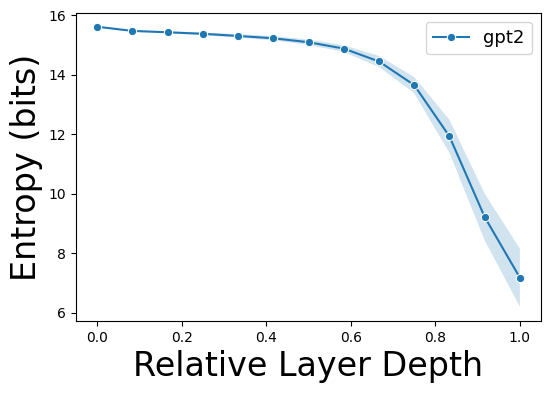

In [7]:
# Initialize variables
entropy_results = {}
nlayers = []

layers = hooked_model.cfg.n_layers
entropy_all = []

# Process dataset
for idx, sample in enumerate(dataset.take(datapoints)):
    prompt = sample["text"][:500]
    layer_output = get_layer_logits_all_tokens(prompt).to(device)
    layer_output = layer_output[:, :, 1:-1, :]

    entropies = [calculate_base2_entropy(layer_output[layer_idx].squeeze(1)).mean().detach().cpu().item() for layer_idx in range(layer_output.shape[0])]
    entropy_all.append(entropies)

entropy_all_np = np.array(entropy_all)
entropy_mean = np.mean(entropy_all_np, axis=0)
entropy_std = np.std(entropy_all_np, axis=0)

entropy_results[model_name] = (entropy_mean, entropy_std)
nlayers.append(layers)

# Clear cache
del entropy_all
del layer_output
del entropies
torch.cuda.empty_cache()

# Plot results
plt.figure(figsize=(6, 4))

for idx, (model_name, (entropy_mean, entropy_std)) in enumerate(entropy_results.items()):
    x_values = np.arange(len(entropy_mean)) / (len(entropy_mean) - 1)
    model_name = model_name.split("/")[-1]
    sns.lineplot(x=x_values, y=entropy_mean, label=f'{model_name}', marker='o')
    plt.fill_between(x_values, entropy_mean - entropy_std, entropy_mean + entropy_std, alpha=0.2)

ax = plt.gca()
plt.xlabel('Relative Layer Depth', fontsize=24)
plt.ylabel('Entropy (bits)', fontsize=24)
plt.legend(fontsize=13)

plt.show()
